In [1]:
import torch                                        # root package
from pathlib import Path
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
import numpy as np
import pandas as pd
import cv2

In [2]:
from fastbook import *

In [3]:
from word_beam_search import WordBeamSearch

# Prepare Dataloaders

In [4]:
# Get labels + filenames
chars = set()
labels = L()
files = L()
bad_samples = L()
data_root_path = Path("../data2")
for line in open(data_root_path/"sentences.txt").read().splitlines():
    if line[0] == "#":
        continue
    tokens = line.split(" ")
    assert len(tokens) > 9
    # Get file names
    filename_token = tokens[0].split("-")
    file_path = data_root_path/f'{filename_token[0]}/{filename_token[0] + "-" + filename_token[1]}/{tokens[0]}.png'  
    if not os.path.getsize(file_path):
        bad_samples.append(file_path)
        continue
    label = " ".join(" ".join(tokens[9:]).split("|"))
    labels.append(label)
    chars = chars.union(set(list(label)))
    files.append(file_path)
    assert len(files) == len(labels)

In [5]:
charlist = sorted(L(chars))

In [6]:
maxLength = 0
for idx, line in enumerate(labels):
    if len(line) > maxLength:
        maxLength = len(line)
        print(line)

A MOVE to stop Mr. Gaitskell from
nominating any more Labour life Peers
Griffiths , M P for Manchester Exchange .
A MOVE to stop Mr. Gaitskell from nominating
any more Labour life Peers is to be made at a
and he is to be backed by Mr. Will Griffiths ,
Though they may gather some Left-wing support , a
ment Bill which brought life peers into existence , they
Delegates from Mr. Kenneth Kaunda's United National Independence
We believe that a comprehensive medical service , free to the patient
It said that the President and Premier noted " with satisfaction " the
said the Vienna talks " might be the beginning of a slight improvement , "
assuredness " Bella Bella Marie " ( Parlophone ) , a lively song that changes tempo mid-way .


In [7]:
def encode_text(label, max_seq_len=127):
    encoded_label = np.zeros(max_seq_len) - 1
    i = 0
    for word in label:
        word = word.replace("&quot", r'"')
        word = word.replace("&amp", r'&')
        word = word.replace('";', '\"')
        for letter in word:
            encoded_label[i] = charlist.index(letter)
            i += 1
        for idx, val in enumerate(encoded_label):
            if val == -1:
                encoded_label[idx] = 79
    return encoded_label, len(label), label

In [8]:
encoded_labels = L()
for label in labels:
    encoded_labels.append(encode_text(label))

In [9]:
df = pd.DataFrame({
    "fnames": files,
    "labels": labels,
    "encoded_labels": encoded_labels
})

In [10]:
def preprocess(img, imgSize, dataAugmentation=False):
    "put img into target img of size imgSize, transpose for TF and normalize gray-values"
    
    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = np.zeros([imgSize[1], imgSize[0]])
    
    # increase dataset size by applying random stretches to the images
    if dataAugmentation:
        stretch = (random.random() - 0.5) # -0.5 .. +0.5
        wStretched = max(int(img.shape[1] * (1 + stretch)), 1) # random width, but at least 1
        img = cv2.resize(img, (wStretched, img.shape[0])) # stretch horizontally by factor 0.5 .. 1.5
    
    # create target image and copy sample image into it
    (wt, ht) = imgSize
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(img, newSize)
    target = np.ones([ht, wt]) * 255
    target[0:newSize[1], 0:newSize[0]] = img
    
    # transpose for TF
    img = target
    
    # normalize
    #(m, s) = cv2.meanStdDev(img)
    #m = m[0][0]
    #s = s[0][0]
    #img = img - m
    #img = img / s if s>0 else img
    img = img/255
    return img

In [11]:
class Model:
    batchSize = 64
    imgSize = (128, 32)
    maxTextLen = 32
    
@Transform
def img_tfm(x: PILImage):
    data = np.array(x)
    result = torch.from_numpy(preprocess(data, (512, 32), True)).float()
    return result.unsqueeze(0)

def get_x(x): return x['fnames']
def get_y(x): return x['encoded_labels']

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), None),
    get_x = get_x, 
    get_y = get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=img_tfm
)

dset = dblock.datasets(df)

In [12]:
class MyDataSet(Dataset):
    def __init__(self, src, get_x, get_y, item_tfms=None, data_augment=False):
        self.item_tfms=item_tfms
        self.x = get_x(src)
        self.y = get_y(src)
        self.data_augment = data_augment
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = self.x[idx]
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if self.item_tfms:
            img = self.item_tfms(img, (512, 32), self.data_augment)

        return torch.from_numpy(np.expand_dims(img, axis=0)).float(), self.y.values[idx] 
            

In [13]:
df = df.loc[0 : 16703, :]

In [14]:
df = df.sample(frac=1).reset_index(drop=True)

In [15]:
df_train = df.loc[0:13375, :].reset_index()
df_valid = df.loc[13376:, :].reset_index()

In [16]:
train_set = MyDataSet(src=df_train, get_x=get_x, get_y=get_y, item_tfms=preprocess, data_augment=True)
valid_set = MyDataSet(src=df_valid, get_x=get_x, get_y=get_y, item_tfms=preprocess, data_augment=False)

In [17]:
train_dl = DataLoader(train_set, batch_size=64)
valid_dl = DataLoader(valid_set, batch_size=64)

In [18]:
dls2 = DataLoaders(train_dl, valid_dl)

In [46]:
16704*0.2

3340.8

In [ ]:
train_dl

# Model

In [19]:
class CRNN(Module):
    def __init__(self, vocab_sz, bs):
        layers = []
        layers.append(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                      
        layers.append(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        layers.append(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(256)) #[64, 256, 8, 128]
        
        layers.append(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=(2,1), stride=(2, 1))) # [64, 256, 4, 128]
        
        layers.append(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(512))# [64, 512, 4, 128]
        
        layers.append(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))) #[64, 512, 2, 128]
        
        layers.append(nn.Conv2d(512, 512, kernel_size=2, stride=1)) ##[64, 512, 2, 127]
        layers.append(nn.ReLU())

        self.cnn = nn.Sequential(*layers)    
        self.rnn = nn.LSTM(input_size=512, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True) 
        self.h_o = nn.Linear(256*2, vocab_sz + 1)
        self.h = [torch.zeros(2*2, bs, 256).cuda() for _ in range(2)]
    
    def forward(self, x):
        out = self.cnn(x) #N x C x H x W
        out = out.squeeze(2)
        out = out.permute(0, 2, 1)
        res, h = self.rnn(out, self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self):
        for h in self.h: h.zero_()

# Training & Validating

In [116]:
chars = str().join(charlist)
wordChars = open('../data/wordCharList.txt').read().splitlines()[0]
corpus = open('../data/corpus.txt').read()
# init decoder object
# this step usually only has to be done once in a program
beamWidth = 100
lmType = 'NGrams'
lmSmoothing = 0.01
wbs = WordBeamSearch(beamWidth, lmType, lmSmoothing, corpus, chars, wordChars)

def ctc_loss_func(xb, yb):
    preds = F.log_softmax(xb, dim=2)
    preds = preds.permute(1, 0, 2)
    pred_lengths = torch.full(size=(64,), fill_value=127, dtype=torch.long)
    loss = nn.CTCLoss(blank=79)
    targets = yb[0]
    target_lengths = yb[1]
    return loss(preds, targets, pred_lengths, target_lengths)

def my_accuracy(xb, yb):
    print(xb.shape)
    preds = F.log_softmax(xb, dim=2)
    preds = preds.permute(1, 0, 2).cpu().data.numpy()
    res = wbs.compute(preds)
    return res

In [21]:
def train_model(model, opt, epoch=1):
    for i in range(1, epoch+1):
        print("Training")
        batch_losses = L()
        for index, (xb, yb) in enumerate(dls.train):
            opt.zero_grad()
            print("Hello")
            preds = model(xb)
            print(preds)
            loss = ctc_loss_func(preds, yb)
            print(loss)
            loss.backward()
            opt.step()
            batch_losses.append(loss.item())
            print(f"Training Batch {index}...")
        print(f'Epoch {i}/{epoch} Training Loss: {np.array(batch_losses).mean()} ')    
            
        with torch.no_grad():
            print("Validating")
            validate_batch_losses = L()
            for xb, yb in dls.validate:
                preds = model(xb)
                loss = ctc_loss_func(preds, yb)
                validate_batch_losses.append(loss.item())
                
            print(f'Epoch {i}/{epoch} Validation Loss: {np.array(validate_batch_losses).mean()} ')    
        model.reset()
            

In [22]:
dls2 = dls2.cuda()

In [23]:
model = CRNN(len(charlist), 64).cuda()

In [24]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.0001)

In [25]:
xb, yb = dls2.one_batch()

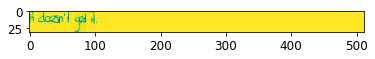

In [26]:
plt.imshow(xb[0][0].cpu().data)

In [27]:
learn = Learner(dls2, model, opt_func=SGD, loss_func=ctc_loss_func)

In [28]:
learn.fit(10, 0.001)

epoch,train_loss,valid_loss,time
0,4.806605,4.328156,04:33
1,4.032254,3.934395,04:12
2,3.787851,3.724915,04:13
3,3.642362,3.592831,04:15
4,3.539836,3.501291,04:26
5,3.470929,3.441061,04:28
6,3.421545,3.398032,04:19
7,3.386374,3.378510,04:14
8,3.358937,3.340766,04:35
9,3.338353,3.348453,04:14


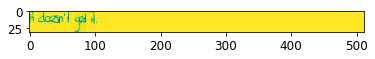

In [99]:
plt.imshow(xb[0][0].cpu().data)

In [170]:
def decode(encoded_label):
    res = ""
    for val in encoded_label:
        if val >= len(charlist):
            continue
        res += charlist[int(val)]
    
    return res

In [166]:
decode(yb[0][0])

"It doesn't get it ."

In [177]:
yb[0][0]

tensor([35., 72.,  0., 56., 67., 57., 71., 66.,  5., 72.,  0., 59., 57., 72.,  0., 61., 72.,  0., 12., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79.,
        79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79.,
        79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79.,
        79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79., 79.], device='cuda:0', dtype=torch.float64)

In [175]:
results[0][0].shape

torch.Size([80])

In [180]:
torch.topk(results[0][0], 23)

torch.return_types.topk(
values=tensor([ 6.6567,  3.3153,  2.7651,  2.3725,  2.2075,  2.1808,  2.0791,  2.0687,  2.0608,  1.9657,  1.8980,  1.4804,  1.3798,  0.9676,  0.8225,  0.8057,  0.6704,  0.6537,  0.5671,  0.5510,  0.4103,
         0.3926,  0.1763,  0.0741, -0.1171]),
indices=tensor([79,  0, 57, 72, 67, 53, 66, 71, 61, 70, 60, 56, 64, 73, 12, 55, 65, 58, 75, 59, 68, 77, 54, 10, 74]))

In [171]:
decode(texts[0])

'     entertainment'

In [ ]:
train_ds = dls.train_ds
valid_ds = dls.valid_ds
train_dl = DataLoader(train_ds, batch_size=64)
valid_dl = DataLoader(valid_ds, batch_size=64)

In [117]:
results.shape

torch.Size([64, 127, 80])

In [118]:
texts = wbs.compute(results.permute(1, 0, 2))

In [131]:
# greedy decoder
def greedy_decoder(data):
	# index for largest probability each row
    
	return [torch.argmax(s, dim=1) for s in data]

In [130]:
results[0].shape

torch.Size([127, 80])

In [142]:
text = torch.argmax(results[0], dim=1)

In [149]:
from math import log

In [150]:
def beam_search_decoder(data, k):
	sequences = [[list(), 0.0]]
	# walk over each step in sequence
	for row in data:
		all_candidates = list()
		# expand each current candidate
		for i in range(len(sequences)):
			seq, score = sequences[i]
			for j in range(len(row)):
				candidate = [seq + [j], score - log(row[j])]
				all_candidates.append(candidate)
		# order all candidates by score
		ordered = sorted(all_candidates, key=lambda tup:tup[1])
		# select k best
		sequences = ordered[:k]
	return sequences

In [152]:
beam_search_decoder(results.data, 3)

ValueError: only one element tensors can be converted to Python scalars

In [145]:
text

tensor([79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79,
        79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79,
        79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79])

In [132]:
texts = greedy_decoder(result)

TypeError: argmax(): argument 'input' (position 1) must be Tensor, not list

In [127]:
greedy_decoder(results[0])

NameError: name 'argmax' is not defined

In [ ]:
doc(DataLoaders)

In [ ]:
dataloaders = DataLoaders(train_dl, valid_dl)

In [ ]:
for data in dls.train_ds:
    print(data)
    break

In [ ]:
doc(DataLoader)

In [ ]:
dl = dls[0]

In [ ]:
path = Path()

In [ ]:
img_path = path/'SimpleHTR'/'data'/'test.png'

In [ ]:
image = tensor(Image.open(img_path))

In [ ]:
show_image(image, cmap='gray')

In [ ]:
image.shape

In [ ]:
kernel_sizes = [5, 5, 3, 3, 3]
channels = [1, 32, 64, 128, 128, 256]
strides = pools = [(2,2), (2,2), (2,1), (2,1), (2,1)] 
paddings = [(2,2), (2,2), (1,1), (1,1), (1,1)] 

In [ ]:
image.shape

In [ ]:
import random
import numpy as np
import cv2


def preprocess(img, imgSize, dataAugmentation=False):
	"put img into target img of size imgSize, transpose for TF and normalize gray-values"

	# there are damaged files in IAM dataset - just use black image instead
	if img is None:
		img = np.zeros([imgSize[1], imgSize[0]])

	# increase dataset size by applying random stretches to the images
	if dataAugmentation:
		stretch = (random.random() - 0.5) # -0.5 .. +0.5
		wStretched = max(int(img.shape[1] * (1 + stretch)), 1) # random width, but at least 1
		img = cv2.resize(img, (wStretched, img.shape[0])) # stretch horizontally by factor 0.5 .. 1.5
	
	# create target image and copy sample image into it
	(wt, ht) = imgSize
	(h, w) = img.shape
	fx = w / wt
	fy = h / ht
	f = max(fx, fy)
	newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
	img = cv2.resize(img, newSize)
	target = np.ones([ht, wt]) * 255
	target[0:newSize[1], 0:newSize[0]] = img

	# transpose for TF
	img = cv2.transpose(target)

	# normalize
	(m, s) = cv2.meanStdDev(img)
	m = m[0][0]
	s = s[0][0]
	img = img - m
	img = img / s if s>0 else img
	return img

In [ ]:
numpy_image = cv2.imread("../SimpleHTR/data/test.png", cv2.IMREAD_GRAYSCALE)

In [ ]:
numpy_image

In [ ]:
pro_image = preprocess(img=numpy_image, imgSize=(128, 32))

In [ ]:
pro_image

In [ ]:
print(pro_image.shape)
show_image(pro_image)

In [ ]:
pro_tensor = torch.from_numpy(pro_image).float()
pro_tensor.shape

In [ ]:
processed = pro_tensor.transpose(0, 1)

In [ ]:
show_image(processed)

In [ ]:
final_tensor = processed.unsqueeze(0).unsqueeze(0)
final_tensor.shape

In [ ]:
final_tensor

In [ ]:
class CRNN(nn.Module):
    def __init__(self):
        kernel_sizes = [5, 5, 3, 3, 3]
        channels = [1, 32, 64, 128, 128, 256]
        strides = pools = [(2,2), (2,2), (1,2), (1,2), (1,2)] 
        paddings = [(2,2), (2,2), (1,1), (1,1), (1,1)]

In [ ]:
class BidirectionalLSTM(Module):
    def __init__(self, nIn, nH, nOut, bs):
        self.rnn = nn.LSTM(nIn, nH, bidirectional=True)
        self.h_o = nn.Linear(nH*2, nOut) # LSTM is bidirectional
        self.h = [torch.zeros(2, bs, nH) for _ in range(2)]
        
    def forward(self, x):
        res, h = self.rnn(x, self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)

In [ ]:
import string
s = string.ascii_lowercase;s

# Prepare Data

In [ ]:
class FilePaths:
    "filenames and paths to data"
    fnCharList = '../model/charList.txt'
    fnAccuracy = '../model/accuracy.txt'
    fnTrain = '../data/'
    fnInfer = '../data/test.png'
    fnCorpus = '../data/corpus.txt'

In [ ]:
import os
import random
import numpy as np
import cv2


def preprocess(img, imgSize, dataAugmentation=False):
    "put img into target img of size imgSize, transpose for TF and normalize gray-values"
    
    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = np.zeros([imgSize[1], imgSize[0]])
    
    # increase dataset size by applying random stretches to the images
    if dataAugmentation:
        stretch = (random.random() - 0.5) # -0.5 .. +0.5
        wStretched = max(int(img.shape[1] * (1 + stretch)), 1) # random width, but at least 1
        img = cv2.resize(img, (wStretched, img.shape[0])) # stretch horizontally by factor 0.5 .. 1.5
    
    # create target image and copy sample image into it
    (wt, ht) = imgSize
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(img, newSize)
    target = np.ones([ht, wt]) * 255
    target[0:newSize[1], 0:newSize[0]] = img
    
    # transpose for TF
    img = cv2.transpose(target)
    
    # normalize
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    return img


class Sample:
    "sample from the dataset"
    def __init__(self, gtText, filePath):
        self.gtText = gtText
        self.filePath = filePath


class Batch:
    "batch containing images and ground truth texts"
    def __init__(self, gtTexts, imgs):
        self.imgs = torch.from_numpy(np.stack(imgs, axis=0)).float()
        self.gtTexts = gtTexts
        
class DataLoader:
    "loads data which corresponds to IAM format, see: http://www.fki.inf.unibe.ch/databases/iam-handwriting-database" 
    
    def __init__(self, file_path, batch_size, image_size, max_seq_len):
        "loader for dataset at given location, preprocess images and text according to parameters"
    
        assert file_path[-1]=='/'
    
        self.dataAugmentation = False
        self.currIdx = 0
        self.batchSize = batch_size
        self.imgSize = image_size
        self.samples = []
    
        f=open(file_path+'words.txt')
        chars = set()
        bad_samples = []
        bad_samples_reference = ['a01-117-05-02.png', 'r06-022-03-05.png']
        for line in f:
            # ignore comment line
            if not line or line[0]=='#':
                continue
            
            lineSplit = line.strip().split(' ')
            assert len(lineSplit) >= 9
            
            # filename: part1-part2-part3 --> part1/part1-part2/part1-part2-part3.png
            fileNameSplit = lineSplit[0].split('-')
            fileName = file_path + 'words/' + fileNameSplit[0] + '/' + fileNameSplit[0] + '-' + fileNameSplit[1] + '/' + lineSplit[0] + '.png'
    
            # GT text are columns starting at 9
            gtText = self.truncateLabel(' '.join(lineSplit[8:]), max_seq_len)
            chars = chars.union(set(list(gtText)))
    
            # check if image is not empty
            if not os.path.getsize(fileName):
                bad_samples.append(lineSplit[0] + '.png')
                continue
    
            # put sample into list
            self.samples.append(Sample(gtText, fileName))
    
        # some images in the IAM dataset are known to be damaged, don't show warning for them
        if set(bad_samples) != set(bad_samples_reference):
            print("Warning, damaged images found:", bad_samples)
            print("Damaged images expected:", bad_samples_reference)
    
        # split into training and validation set: 95% - 5%
        splitIdx = int(0.95 * len(self.samples))
        self.trainSamples = self.samples[:splitIdx]
        self.validationSamples = self.samples[splitIdx:]
    
        # put words into lists
        self.trainWords = [x.gtText for x in self.trainSamples]
        self.validationWords = [x.gtText for x in self.validationSamples]
    
        # number of randomly chosen samples per epoch for training 
        self.numTrainSamplesPerEpoch = int(0.95 * len(self.samples)) 
        
        # start with train set
        self.trainSet()
    
        # list of all chars in dataset
        self.charList = sorted(list(chars))
    
    def getBatchSize(self):
        return self.batchSize
    
    def truncateLabel(self, text, maxTextLen):
        # ctc_loss can't compute loss if it cannot find a mapping between text label and input 
        # labels. Repeat letters cost double because of the blank symbol needing to be inserted.
        # If a too-long label is provided, ctc_loss returns an infinite gradient
        cost = 0
        for i in range(len(text)):
            if i != 0 and text[i] == text[i-1]:
                cost += 2
            else:
                cost += 1
            if cost > maxTextLen:
                return text[:i]
        return text
    
    
    def trainSet(self):
        "switch to randomly chosen subset of training set"
        self.dataAugmentation = True
        self.currIdx = 0
        random.shuffle(self.trainSamples)
        #self.samples = self.trainSamples[:self.numTrainSamplesPerEpoch]
        self.samples = self.trainSamples
    
    
    def validationSet(self):
        "switch to validation set"
        self.dataAugmentation = False
        self.currIdx = 0
        self.samples = self.validationSamples
    
    
    def getIteratorInfo(self):
        "current batch index and overall number of batches"
        return (self.currIdx // self.batchSize + 1, len(self.samples) // self.batchSize)
    
    
    def hasNext(self):
        "iterator"
        return self.currIdx + self.batchSize <= len(self.samples)
        
        
    def getNext(self):
        "iterator"
        batchRange = range(self.currIdx, self.currIdx + self.batchSize)
        gtTexts = [self.samples[i].gtText for i in batchRange]
        imgs = [preprocess(cv2.imread(self.samples[i].filePath, cv2.IMREAD_GRAYSCALE), self.imgSize, self.dataAugmentation) for i in batchRange]
        self.currIdx += self.batchSize
        return self.get_data(Batch(gtTexts, imgs))
    
    def get_data(self, batch):
        targets = []
        target_lengths = []
        for word in batch.gtTexts:
            count = 0
            for c in word:
                targets.append(dl.charList.index(c))
                count += 1
            target_lengths.append(count)
            assert len(targets) == sum(target_lengths)
        return batch.imgs.unsqueeze(1), tensor(*targets), tensor(*target_lengths)
    
    def one_batch(self):
        batchRange = range(0, 64)
        gtTexts = [self.samples[i].gtText for i in batchRange]
        imgs = [preprocess(cv2.imread(self.samples[i].filePath, cv2.IMREAD_GRAYSCALE), self.imgSize, self.dataAugmentation) for i in batchRange]
        return Batch(gtTexts, imgs)
    

In [ ]:
bs = 64
img_size = (128, 32)
max_seq_len = 32

In [ ]:
dl = DataLoader(FilePaths.fnTrain, bs, img_size, max_seq_len)

In [ ]:
sample_batch = dls.one_batch()

In [ ]:
imgs, labels = sample_batch.imgs, sample_batch.gtTexts

In [ ]:
show_image(imgs[0])
print(labels[0])

# MODEL

In [ ]:
class CRNN(Module):
    def __init__(self, vocab_sz, bs):
        kernel_sizes = [5, 5, 3, 3, 3]
        channels = [1, 32, 64, 128, 128, 256]
        strides = pools = [(2,2), (2,2), (1,2), (1,2), (1,2)] 
        paddings = [(2,2), (2,2), (1,1), (1,1), (1,1)] 
        layers = []
        for i in range(len(strides)):
            layers.append(nn.Conv2d(channels[i], channels[i+1], kernel_size=kernel_sizes[i], stride=1, padding=paddings[i]))
            layers.append(nn.BatchNorm2d(channels[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=(pools[i][0], pools[i][1]), stride=(strides[i][0], strides[i][1])))
        self.cnn = nn.Sequential(*layers)    
        
        self.rnn = nn.LSTM(input_size=256, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True) 
        self.h_o = nn.Linear(256*2, vocab_sz + 1)
        self.h = [torch.zeros(2*2, bs, 256).cuda() for _ in range(2)]
    
    def forward(self, x):
        out = self.cnn(x) #N x C x W x H
        out = out.squeeze(3)
        out = out.permute(0, 2, 1)
        res, h = self.rnn(out, self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self):
        for h in self.h: h.zero_()

# Training & Validating

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

In [ ]:
import numpy as np

def ctc_loss_func(preds, targets, target_lengths):
    preds = F.log_softmax(preds, dim=2)
    preds = preds.permute(1, 0, 2)
    pred_lengths = torch.full(size=(64,), fill_value=32, dtype=torch.long)
    loss = nn.CTCLoss(blank=79, reduction='sum')
    return loss(preds, targets, pred_lengths, target_lengths)

def train_epoch(model, loader, opt, loss_func):
    batch_losses = []
    while loader.hasNext():
        iterInfo = loader.getIteratorInfo()
        imgs, targets, target_lengths = loader.getNext()
        # Move input data to GPU if it is available
        imgs = imgs.to(device)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)
        # Make predictions
        preds = model(imgs)
        # Calculate the loss 
        loss = loss_func(preds, targets, target_lengths)
        loss = loss/loader.getBatchSize()
        loss.backward()
        opt.step()
        opt.zero_grad()
        batch_losses.append(loss.item())
        if (iterInfo[0] % 100 == 299):
            print(f'Batch {iterInfo[0]}/{iterInfo[1]} loss: {loss}')
    return np.array(batch_losses).mean()

def validate_epoch(model, dl, opt, loss_func):
    batch_losses = []
    while dl.hasNext():
        imgs, targets, target_lengths = dl.getNext()
        # Move input data to GPU if it is available
        imgs = imgs.to(device)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)
        # Make predictions
        preds = model(imgs)
        # Calculate the loss 
        loss = loss_func(preds, targets, target_lengths)
        loss = loss/dl.getBatchSize()
        batch_losses.append(loss.item())
    return np.array(batch_losses).mean()

            
def train_model(model, dl, opt, loss_func, epoch=1):
    for i in range(1, epoch + 1):
        dl.trainSet()
        epoch_loss = train_epoch(model, dl, opt, loss_func)
        print(f"Epoch {i} / {epoch} loss: {epoch_loss}")
        model.reset()
        with torch.no_grad():
            dl.validationSet()
            validation_loss = validate_epoch(model, dl, opt, loss_func)
            print(f"Epoch {i}/{epoch} validation loss: {validation_loss}")

In [ ]:
model = CRNN(len(dl.charList), 64).to(device)
opt = torch.optim.RMSprop(model.parameters(), lr=0.0001)

In [ ]:
train_model(model, dl, opt, ctc_loss_func, epoch=2)

In [ ]:
path = Path("model-checkpoint")

In [ ]:
torch.save(model.state_dict(), path)

In [ ]:
dl.trainSet()

In [ ]:
batch = dl.one_batch()

In [ ]:
imgs, labels = batch.imgs, batch.gtTexts

In [ ]:
chars = str().join(dl.charList)
wordChars = open('../data/wordCharList.txt').read().splitlines()[0]
corpus = open('../data/corpus.txt').read()

In [ ]:
chars = str().join(dl.charList)
wordChars = open('../data/wordCharList.txt').read().splitlines()[0]
corpus = open('../data/corpus.txt').read()
# init decoder object
# this step usually only has to be done once in a program
beamWidth = 25
lmType = 'NGrams'
lmSmoothing = 0.01
wbs = WordBeamSearch(beamWidth, lmType, lmSmoothing, corpus, chars, wordChars)

# feed NumPy array of shape TxBxC to decoder, which returns list of decoded texts
#res = wbs.compute(feedMat)

In [ ]:
model.eval()

In [ ]:
preds = model(imgs.unsqueeze(1).to(device))

In [ ]:
feedMat = preds.permute(1,0,2).detach()

In [ ]:
feedMat = feedMat.to(torch.device('cpu')).numpy()

In [ ]:
res = wbs.compute(feedMat)

In [ ]:
def decode(pred):
    blank = 79
    s = ''
    for label in pred:
        if label == blank:
            break
        s += chars[label]  #
    print(s)

In [ ]:
imgs.shape

In [ ]:
show_image(imgs[6].squeeze()), labels[6]

In [ ]:
decode(res[6])

In [ ]:
show_image(preds[0])

In [ ]:
blank = 79
s = ''
for label in res[10]:
    if label == blank:
        break
    s += chars[label]  #
print(s)

In [ ]:
show_image(imgs[10][0]), batch.gtTexts[10]

In [ ]:
targets = []
target_lengths = []
for word in ground_truth:
    count = 0
    for c in word:
        targets.append(dl.charList.index(c))
        count += 1
    target_lengths.append(count)
targets = tensor(*targets)
target_lengths = tensor(*target_lengths)

In [ ]:
def loss_func(preds, targets, target_lengths):
    preds = F.log_softmax(preds, dim=2)
    preds = preds.permute(1, 0, 2)
    pred_lengths = torch.full(size=(64,), fill_value=32, dtype=torch.long)
    loss = nn.CTCLoss(blank=79)
    return loss(preds, targets, pred_lengths, target_lengths)

In [ ]:
class Model:
    batchSize = 64
    imgSize = (128, 32)
    maxTextLen = 32
    
@Transform
def img_tfm(x: PILImage):
    data = np.array(x)
    result = torch.from_numpy(preprocess(data, (512, 32), True)).float()
    return result.unsqueeze(0)

def get_x(r): return r['fnames']
def get_y(r): return r['encoded_labels']

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), None),
    get_x = get_x, 
    get_y = get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=img_tfm
)

In [ ]:
def preprocess(img, imgSize, dataAugmentation=False):
	"put img into target img of size imgSize, transpose for TF and normalize gray-values"

	# there are damaged files in IAM dataset - just use black image instead
	if img is None:
		img = np.zeros([imgSize[1], imgSize[0]])

	# increase dataset size by applying random stretches to the images
	if dataAugmentation:
		stretch = (random.random() - 0.5) # -0.5 .. +0.5
		wStretched = max(int(img.shape[1] * (1 + stretch)), 1) # random width, but at least 1
		img = cv2.resize(img, (wStretched, img.shape[0])) # stretch horizontally by factor 0.5 .. 1.5
	
	# create target image and copy sample image into it
	(wt, ht) = imgSize
	(h, w) = img.shape
	fx = w / wt
	fy = h / ht
	f = max(fx, fy)
	newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
	img = cv2.resize(img, newSize)
	target = np.ones([ht, wt]) * 255
	target[0:newSize[1], 0:newSize[0]] = img

	# transpose for TF
	img = cv2.transpose(target)

	# normalize
	(m, s) = cv2.meanStdDev(img)
	m = m[0][0]
	s = s[0][0]
	img = img - m
	img = img / s if s>0 else img
	return img

In [ ]:
show_image(preprocess(np.array(Image.open(files[0])), (512, 32)))

In [ ]:
a = preprocess(np.array(Image.open(files[0])), (512, 32))

## Prepare Dataset

In [ ]:
import os
import random
import numpy as np
import cv2


def preprocess(img, imgSize, dataAugmentation=False):
	"put img into target img of size imgSize, transpose for TF and normalize gray-values"

	# there are damaged files in IAM dataset - just use black image instead
	if img is None:
		img = np.zeros([imgSize[1], imgSize[0]])

	# increase dataset size by applying random stretches to the images
	if dataAugmentation:
		stretch = (random.random() - 0.5) # -0.5 .. +0.5
		wStretched = max(int(img.shape[1] * (1 + stretch)), 1) # random width, but at least 1
		img = cv2.resize(img, (wStretched, img.shape[0])) # stretch horizontally by factor 0.5 .. 1.5
	
	# create target image and copy sample image into it
	(wt, ht) = imgSize
	(h, w) = img.shape
	fx = w / wt
	fy = h / ht
	f = max(fx, fy)
	newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
	img = cv2.resize(img, newSize)
	target = np.ones([ht, wt]) * 255
	target[0:newSize[1], 0:newSize[0]] = img

	# transpose for TF
	img = cv2.transpose(target)

	# normalize
	(m, s) = cv2.meanStdDev(img)
	m = m[0][0]
	s = s[0][0]
	img = img - m
	img = img / s if s>0 else img
	return img

class Sample:
	"sample from the dataset"
	def __init__(self, gtText, filePath):
		self.gtText = gtText
		self.filePath = filePath


class Batch:
    "batch containing images and ground truth texts"
    def __init__(self, gtTexts, imgs):
        self.imgs = torch.from_numpy(np.stack(imgs, axis=0)).float()
        self.gtTexts = gtTexts


class DataLoader:
	"loads data which corresponds to IAM format, see: http://www.fki.inf.unibe.ch/databases/iam-handwriting-database" 

	def __init__(self, filePath, batchSize, imgSize, maxTextLen):
		"loader for dataset at given location, preprocess images and text according to parameters"

		assert filePath[-1]=='/'

		self.dataAugmentation = False
		self.currIdx = 0
		self.batchSize = batchSize
		self.imgSize = imgSize
		self.samples = []
	
		f=open(filePath+'words.txt')
		chars = set()
		bad_samples = []
		bad_samples_reference = ['a01-117-05-02.png', 'r06-022-03-05.png']
		for line in f:
			# ignore comment line
			if not line or line[0]=='#':
				continue
			
			lineSplit = line.strip().split(' ')
			assert len(lineSplit) >= 9
			
			# filename: part1-part2-part3 --> part1/part1-part2/part1-part2-part3.png
			fileNameSplit = lineSplit[0].split('-')
			fileName = filePath + 'words/' + fileNameSplit[0] + '/' + fileNameSplit[0] + '-' + fileNameSplit[1] + '/' + lineSplit[0] + '.png'

			# GT text are columns starting at 9
			gtText = self.truncateLabel(' '.join(lineSplit[8:]), maxTextLen)
			chars = chars.union(set(list(gtText)))

			# check if image is not empty
			if not os.path.getsize(fileName):
				bad_samples.append(lineSplit[0] + '.png')
				continue

			# put sample into list
			self.samples.append(Sample(gtText, fileName))

		# some images in the IAM dataset are known to be damaged, don't show warning for them
		if set(bad_samples) != set(bad_samples_reference):
			print("Warning, damaged images found:", bad_samples)
			print("Damaged images expected:", bad_samples_reference)

		# split into training and validation set: 95% - 5%
		splitIdx = int(0.95 * len(self.samples))
		self.trainSamples = self.samples[:splitIdx]
		self.validationSamples = self.samples[splitIdx:]

		# put words into lists
		self.trainWords = [x.gtText for x in self.trainSamples]
		self.validationWords = [x.gtText for x in self.validationSamples]

		# number of randomly chosen samples per epoch for training 
		self.numTrainSamplesPerEpoch = 25000 
		
		# start with train set
		self.trainSet()

		# list of all chars in dataset
		self.charList = sorted(list(chars))

	def getBatchSize(self):
		return self.batchSize

	def truncateLabel(self, text, maxTextLen):
		# ctc_loss can't compute loss if it cannot find a mapping between text label and input 
		# labels. Repeat letters cost double because of the blank symbol needing to be inserted.
		# If a too-long label is provided, ctc_loss returns an infinite gradient
		cost = 0
		for i in range(len(text)):
			if i != 0 and text[i] == text[i-1]:
				cost += 2
			else:
				cost += 1
			if cost > maxTextLen:
				return text[:i]
		return text


	def trainSet(self):
		"switch to randomly chosen subset of training set"
		self.dataAugmentation = True
		self.currIdx = 0
		random.shuffle(self.trainSamples)
		self.samples = self.trainSamples[:self.numTrainSamplesPerEpoch]

	
	def validationSet(self):
		"switch to validation set"
		self.dataAugmentation = False
		self.currIdx = 0
		self.samples = self.validationSamples


	def getIteratorInfo(self):
		"current batch index and overall number of batches"
		return (self.currIdx // self.batchSize + 1, len(self.samples) // self.batchSize)


	def hasNext(self):
		"iterator"
		return self.currIdx + self.batchSize <= len(self.samples)
		
		
	def getNext(self):
		"iterator"
		batchRange = range(self.currIdx, self.currIdx + self.batchSize)
		gtTexts = [self.samples[i].gtText for i in batchRange]
		imgs = [preprocess(cv2.imread(self.samples[i].filePath, cv2.IMREAD_GRAYSCALE), self.imgSize, self.dataAugmentation) for i in batchRange]
		self.currIdx += self.batchSize
		return Batch(gtTexts, imgs)

In [ ]:
def my_get_image_files(path):
    bad_samples = []
    bad_sample_references = ['a01-117-05-02.png', 'r06-022-03-05.png']
    finals = L()
    files = get_image_files(path)
    for f in files:
        # check if image is empty
        if not os.path.getsize(f):
            bad_samples.append(str(f).split('/')[-1])
        else:
            finals.append(f)
            
    if set(bad_samples) != set(bad_sample_references):
        print("Warning, damaged images found:", bad_samples)
        print("Damaged images expected:", bad_sample_references)
        
    return finals

def truncateLabel(text, maxTextLen):
    # ctc_loss can't compute loss if it cannot find a mapping between text label and input 
    # labels. Repeat letters cost double because of the blank symbol needing to be inserted.
    # If a too-long label is provided, ctc_loss returns an infinite gradient
    cost = 0
    for i in range(len(text)):
        if i != 0 and text[i] == text[i-1]:
            cost += 2
        else:
            cost += 1
        if cost > maxTextLen:
            return text[:i]
    return text

def my_get_label(fname):
    path = Path("../data/words.txt")
    maxTextLen = 32
    for idx, line in enumerate(f):
        if (line[0] != '#'):
            print(idx, truncateLabel(' '.join(line.strip().split(" ")[8:]), maxTextLen))
    return 

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = my_get_image_files,
    get_y = my_get_label
)

In [ ]:
import pandas as pd

In [ ]:
path = Path("../data/words.txt")
f = open(path)
file_path = Path("../data/words")
maxTextLen = 32
fnames = L()
labels = L()
chars = set()
bad_samples = []
bad_sample_references = ['a01-117-05-02.png', 'r06-022-03-05.png']
for line in f:
    if line[0] != "#":
        words = line.strip().split(" ")
        assert len(words) >= 9
        
        # Get ground truth text
        label = truncateLabel(' '.join(words[8:]), maxTextLen)
        chars = chars.union(set(list(label)))
        # Get file name
        file_name_split = words[0].split('-')
        file_name = file_path/file_name_split[0]/ \
            (file_name_split[0] + "-" + file_name_split[1])/ \
            (words[0]+".png")
        
        # check if image is empty
        if not os.path.getsize(file_name):
            bad_samples.append(str(file_name).split('/')[-1])
        else:
            fnames.append(file_name)
            labels.append(label)
            
assert len(labels) == len(fnames)
if set(bad_samples) != set(bad_sample_references):
    print("Warning, damaged images found:", bad_samples)
    print("Damaged images expected:", bad_sample_references)

In [ ]:
df = pd.DataFrame({
    "fname": fnames,
    "label": labels
})

In [ ]:
import os
import random
import numpy as np
import cv2


def preprocess(img, imgSize, dataAugmentation=False):
	"put img into target img of size imgSize, transpose for TF and normalize gray-values"

	# there are damaged files in IAM dataset - just use black image instead
	if img is None:
		img = np.zeros([imgSize[1], imgSize[0]])

	# increase dataset size by applying random stretches to the images
	if dataAugmentation:
		stretch = (random.random() - 0.5) # -0.5 .. +0.5
		wStretched = max(int(img.shape[1] * (1 + stretch)), 1) # random width, but at least 1
		img = cv2.resize(img, (wStretched, img.shape[0])) # stretch horizontally by factor 0.5 .. 1.5
	
	# create target image and copy sample image into it
	(wt, ht) = imgSize
	(h, w) = img.shape
	fx = w / wt
	fy = h / ht
	f = max(fx, fy)
	newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
	img = cv2.resize(img, newSize)
	target = np.ones([ht, wt]) * 255
	target[0:newSize[1], 0:newSize[0]] = img

	# transpose for TF
	img = cv2.transpose(target)

	# normalize
	(m, s) = cv2.meanStdDev(img)
	m = m[0][0]
	s = s[0][0]
	img = img - m
	img = img / s if s>0 else img
	return img

class Sample:
	"sample from the dataset"
	def __init__(self, gtText, filePath):
		self.gtText = gtText
		self.filePath = filePath


class Batch:
    "batch containing images and ground truth texts"
    def __init__(self, gtTexts, imgs):
        self.imgs = torch.from_numpy(np.stack(imgs, axis=0)).float()
        self.gtTexts = gtTexts


class DataLoader:
	"loads data which corresponds to IAM format, see: http://www.fki.inf.unibe.ch/databases/iam-handwriting-database" 

	def __init__(self, filePath, batchSize, imgSize, maxTextLen):
		"loader for dataset at given location, preprocess images and text according to parameters"

		assert filePath[-1]=='/'

		self.dataAugmentation = False
		self.currIdx = 0
		self.batchSize = batchSize
		self.imgSize = imgSize
		self.samples = []
	
		f=open(filePath+'words.txt')
		chars = set()
		bad_samples = []
		bad_samples_reference = ['a01-117-05-02.png', 'r06-022-03-05.png']
		for line in f:
			# ignore comment line
			if not line or line[0]=='#':
				continue
			
			lineSplit = line.strip().split(' ')
			assert len(lineSplit) >= 9
			
			# filename: part1-part2-part3 --> part1/part1-part2/part1-part2-part3.png
			fileNameSplit = lineSplit[0].split('-')
			fileName = filePath + 'words/' + fileNameSplit[0] + '/' + fileNameSplit[0] + '-' + fileNameSplit[1] + '/' + lineSplit[0] + '.png'

			# GT text are columns starting at 9
			gtText = self.truncateLabel(' '.join(lineSplit[8:]), maxTextLen)
			chars = chars.union(set(list(gtText)))

			# check if image is not empty
			if not os.path.getsize(fileName):
				bad_samples.append(lineSplit[0] + '.png')
				continue

			# put sample into list
			self.samples.append(Sample(gtText, fileName))

		# some images in the IAM dataset are known to be damaged, don't show warning for them
		if set(bad_samples) != set(bad_samples_reference):
			print("Warning, damaged images found:", bad_samples)
			print("Damaged images expected:", bad_samples_reference)

		# split into training and validation set: 95% - 5%
		splitIdx = int(0.95 * len(self.samples))
		self.trainSamples = self.samples[:splitIdx]
		self.validationSamples = self.samples[splitIdx:]

		# put words into lists
		self.trainWords = [x.gtText for x in self.trainSamples]
		self.validationWords = [x.gtText for x in self.validationSamples]

		# number of randomly chosen samples per epoch for training 
		self.numTrainSamplesPerEpoch = 25000 
		
		# start with train set
		self.trainSet()

		# list of all chars in dataset
		self.charList = sorted(list(chars))

	def getBatchSize(self):
		return self.batchSize

	def truncateLabel(self, text, maxTextLen):
		# ctc_loss can't compute loss if it cannot find a mapping between text label and input 
		# labels. Repeat letters cost double because of the blank symbol needing to be inserted.
		# If a too-long label is provided, ctc_loss returns an infinite gradient
		cost = 0
		for i in range(len(text)):
			if i != 0 and text[i] == text[i-1]:
				cost += 2
			else:
				cost += 1
			if cost > maxTextLen:
				return text[:i]
		return text


	def trainSet(self):
		"switch to randomly chosen subset of training set"
		self.dataAugmentation = True
		self.currIdx = 0
		random.shuffle(self.trainSamples)
		self.samples = self.trainSamples[:self.numTrainSamplesPerEpoch]

	
	def validationSet(self):
		"switch to validation set"
		self.dataAugmentation = False
		self.currIdx = 0
		self.samples = self.validationSamples


	def getIteratorInfo(self):
		"current batch index and overall number of batches"
		return (self.currIdx // self.batchSize + 1, len(self.samples) // self.batchSize)


	def hasNext(self):
		"iterator"
		return self.currIdx + self.batchSize <= len(self.samples)
		
		
		"iterator"
		batchRange = range(self.currIdx, self.currIdx + self.batchSize)
		gtTexts = [self.samples[i].gtText for i in batchRange]
		imgs = [preprocess(cv2.imread(self.samples[i].filePath, cv2.IMREAD_GRAYSCALE), self.imgSize, self.dataAugmentation) for i in batchRange]
		self.currIdx += self.batchSize
		return Batch(gtTexts, imgs)

In [ ]:
df.shape

In [ ]:
import numpy as np
class Model:
    batchSize = 64
    imgSize = (128, 32)
    maxTextLen = 32
    
@Transform
def img_tfm(x: PILImage):
    data = np.array(x)
    result = torch.from_numpy(preprocess(data, (128, 32), True)).float()
    return result.unsqueeze(0)
def get_x(r): return r['fname']
def get_y(r): return r['label']

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), None),
    get_x = get_x, 
    get_y = get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=img_tfm
)

In [ ]:
def get_x(r): return r['fname']
def get_y(r): return r['label']

dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), None),
    get_x = get_x, 
    get_y = get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=img_tfm
)

In [ ]:
dls = dblock.dataloaders(df, bs=64)

In [ ]:
charList = sorted(list(chars))

In [ ]:
chars = str().join(charList)
wordChars = open('../data/wordCharList.txt').read().splitlines()[0]
corpus = open('../data/corpus.txt').read()
# init decoder object
# this step usually only has to be done once in a program
beamWidth = 25
lmType = 'NGrams'
lmSmoothing = 0.01
wbs = WordBeamSearch(beamWidth, lmType, lmSmoothing, corpus, chars, wordChars)

# feed NumPy array of shape TxBxC to decoder, which returns list of decoded texts
#res = wbs.compute(feedMat)

def ctc_loss_func(preds, targets, target_lengths, bs=64, seqLen=32):
    preds = F.log_softmax(preds, dim=2)
    preds = preds.permute(1, 0, 2)
    pred_lengths = torch.full(size=(bs,), fill_value=seqLen, dtype=torch.long)
    loss = nn.CTCLoss(blank=79, reduction='sum')
    return loss(preds, targets, pred_lengths, target_lengths)

def get_targets(text):
    targets = []
    target_lengths = []
    for word in text:
        count = 0
        for c in word:
            targets.append(charList.index(c))
            count += 1
        target_lengths.append(count)
        assert len(targets) == sum(target_lengths)
    return tensor(*targets).cuda(), tensor(*target_lengths).cuda()

def calc_grad(xb, yb, model, bs=64):
    targets, target_lengths = get_targets(yb) 
    preds = model(xb)
    loss = ctc_loss_func(preds, targets, target_lengths)
    loss = loss/bs
    loss.backward()
    return loss
    
def train_epoch(dl, model, opt):
    i = 1
    length = len(dl)
    for xb, yb in dl:
        loss = calc_grad(xb, yb, model)
        print(f'batch: {i}/{length} loss: {loss}')
        opt.step()
        opt.zero_grad()
        i+=1

def decode(pred):
    blank = 79
    s = ''
    for label in pred:
        if label == blank:
            break
        s += chars[label]  #
    print(s)
    
def batch_accuracy(xb, yb):
    feedMat = xb.permute(1,0,2).detach().numpy()
    preds = wbs.compute(feedMat)
    for pred in preds:
        text = decode(pred)
        gtext = decode(yb)
        if (text == gtext[:len(text)]): count+=1;
    return count / len(preds)
    

def validate_epoch(dl, model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in dl]
    return round(torch.stack(accs).mean().item(), 4)
    
from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep
def train_model(dls, model, opt, epochs=1):
    train_dl = dls.train
    valid_dl = dls.valid
    train_epoch(train_dl, model, opt)
    print(f'Epoch: {i}/{epochs} Loss: {validate_epoch(valid_dl, model)}')
    model.reset()
    

In [ ]:
# if torch.cuda.is_available():
#     device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
#     print("Running on the GPU")
# else:
#     device = torch.device("cpu")
#     print("Running on the CPU")

In [ ]:
class CRNN(Module):
    def __init__(self, vocab_sz, bs):
        kernel_sizes = [5, 5, 3, 3, 3]
        channels = [1, 32, 64, 128, 128, 256]
        strides = pools = [(2,2), (2,2), (1,2), (1,2), (1,2)] 
        paddings = [(2,2), (2,2), (1,1), (1,1), (1,1)] 
        layers = []
        for i in range(len(strides)):
            layers.append(nn.Conv2d(channels[i], channels[i+1], kernel_size=kernel_sizes[i], stride=1, padding=paddings[i]))
            layers.append(nn.BatchNorm2d(channels[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=(pools[i][0], pools[i][1]), stride=(strides[i][0], strides[i][1])))
        self.cnn = nn.Sequential(*layers)    
        
        self.rnn = nn.LSTM(input_size=256, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True) 
        self.h_o = nn.Linear(256*2, vocab_sz + 1)
        self.h = [torch.zeros(2*2, bs, 256) for _ in range(2)]
    
    def forward(self, x):
        out = self.cnn(x) #N x C x W x H
        out = out.squeeze(3)
        out = out.permute(0, 2, 1)
        res, h = self.rnn(out, self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self):
        for h in self.h: h.zero_()

In [ ]:
model = CRNN(len(charList), 64)

In [ ]:
# if(torch.cuda.is_available()):
#     print("Using GPU")
#     dls.cuda()# rnn is your model 

In [ ]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.0001)

In [ ]:
device = torch.device("cpu")
dls = dls.to(device)

In [ ]:
train_model(dls, model, opt)